In [1]:
from env import TestEnv
from executor import Executor
from trace import Trace
import json

In [2]:
from conf import LisaLogging
import logging
# LisaLogging.setup(level=logging.WARNING)

# Run a workload

In [3]:
te = TestEnv({
    'platform': 'android',
    'board': 'pixel',
    'rtapp-calib': {"0": 104, "1": 106, "2": 78, "3": 78}
}, test_conf = {
    'ftrace': {
        'events': ['sched_switch', 'cpu_idle', 'irq*']
    }
})

In [4]:
te.calibration(force=True)

{0: 105, 1: 106, 2: 78, 3: 79}

In [5]:
executor = Executor(te, {
    'confs': [{'tag': 'myconf', 'flags': ['ftrace']}],
    'wloads': {    
        'one_small' : {
            'type' : 'rt-app',
            'conf' : {
                'class' : 'periodic',
                'params' : {
                    'duty_cycle_pct': 20,
                    'duration_s': 2,
                    'period_ms': 10,
                },
                'tasks' : 1,
                'prefix' : 'many',
            },
        },
    }
})

In [6]:
executor.run()

No handlers could be found for logger "Executor"


# Parse captured ftrace

In [7]:
from trappy.plotter import plot_trace

In [8]:
with open('EnergyModel/pixel.json') as js:
    pixel = json.load(js)

In [9]:
trace = Trace(pixel, executor.experiments[0].out_dir, ['sched_switch', 'cpu_idle', 'irq_handler_entry'])

In [10]:
plot_trace(trace.ftrace)

# Get `irq_handler_entry` event

In [11]:
trace.available_events

['irq_handler_entry', 'sched_switch', 'cpu_idle']

In [12]:
irq = trace.data_frame.trace_event('irq_handler_entry')

# Examine IRQ frequency

In [13]:
import pandas as pd
%matplotlib inline

In [32]:
def plot_irqs(irqs):
    evt_difference = irqs.index[1:] - irqs.index[:-1]
    df = pd.DataFrame({'time_delta': evt_difference, 'time': irqs.index[1:]})
    df.plot(kind='scatter', x='time', y='time_delta', figsize=(8, 8))

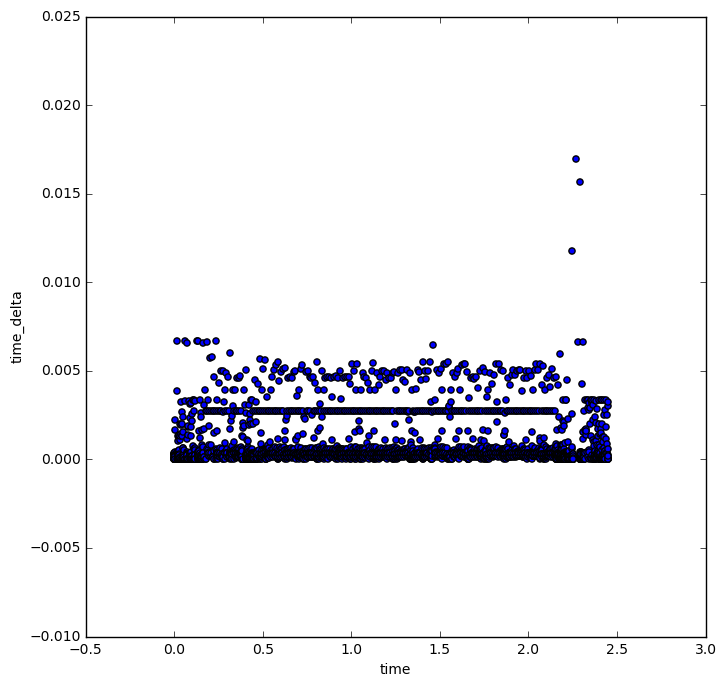

In [33]:
plot_irqs(irq)

In [35]:
irq_cpu1 = irq[irq['__cpu'] == 1]

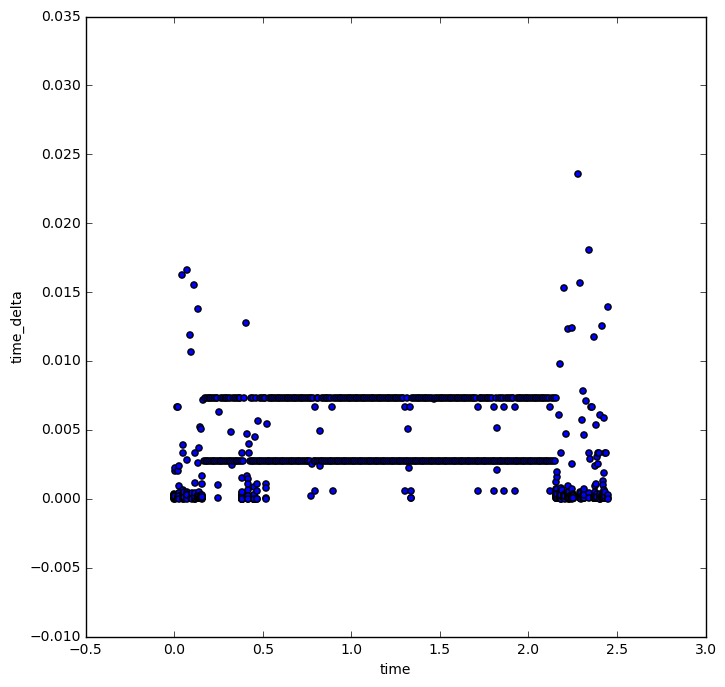

In [36]:
plot_irqs(irq_cpu1)

In [37]:
irq['name'].unique()

array(['cpr3', 'arch_timer', 'dwc3', '408000.qcom,cpu-bwmon', 'wlan_pci',
       'nanohub-irq2', 'nanohub-irq1', 'qcom,smd-rpm',
       'qcom,glink-smem-native-xprt-rpm', 'sps', 'arch_mem_timer',
       'arm-pmu', 'ufshcd', '400f000.qcom,spmi', 'delta-soc', 'mem-avail'], dtype=object)

In [41]:
some_irq = irq[irq['name'] == 'arch_timer']

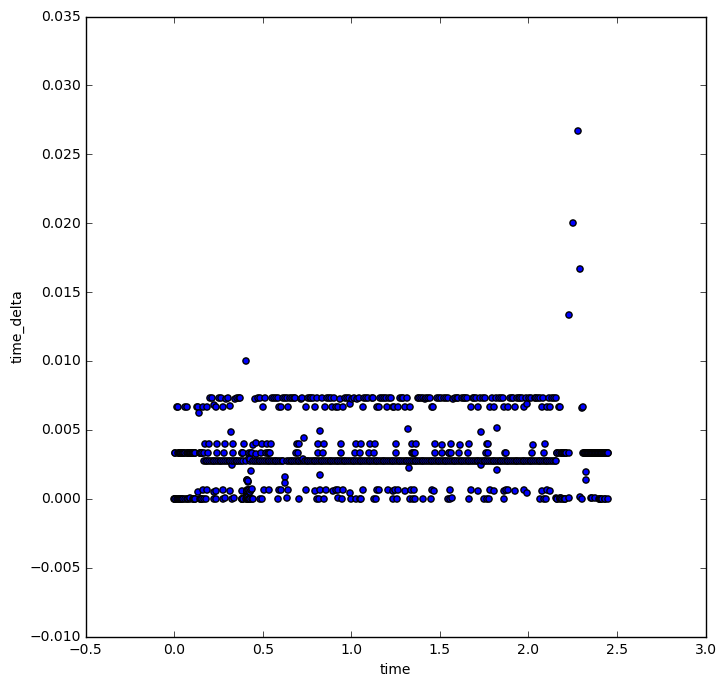

In [42]:
plot_irqs(some_irq)